<a href="https://colab.research.google.com/github/raghuch/EVA8_assignments/blob/main/assignment8/assignment8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!git clone https://github.com/raghuch/EVA8_assignments.git

In [1]:
import sys
import os
#homedir = os.path.dirname(os.path.abspath(__file__))
homedir = os.path.abspath('')
sys.path.append(os.path.dirname(os.path.dirname(homedir)))
#print(os.path.dirname(os.path.dirname(homedir)))
#!pip install torch_lr_finder

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
from torch_lr_finder import LRFinder


SEED = 1
use_cuda = torch.cuda.is_available()
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
from EVA8_assignments.models.custom_resnet import get_customResNet
from EVA8_assignments.models.utils.train_loop import train, test, get_schedulder, sgd_optim
from EVA8_assignments.models.utils.data_utils import get_augmented_cifar10_dataset, default_train_transforms, default_test_transforms, assn8_train_transforms, assn8_test_transforms

In [5]:
custom_resnet = get_customResNet()
custom_resnet = custom_resnet.to(device)

In [17]:
model_copy = copy.deepcopy(custom_resnet)
model_copy.to(device)

customResNet(
  (prep): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (X1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (l2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (X2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [7]:
#These dataloaders are just for OCP LR finding. We don't use any augmentations even for train dataloader
cifar10_trainloader_ocp, cifar10_testloader_ocp = get_augmented_cifar10_dataset("/home/raghuc/work/data/", train_tfms=assn8_test_transforms, test_tfms=assn8_test_transforms, batch_sz=512, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.64E-03


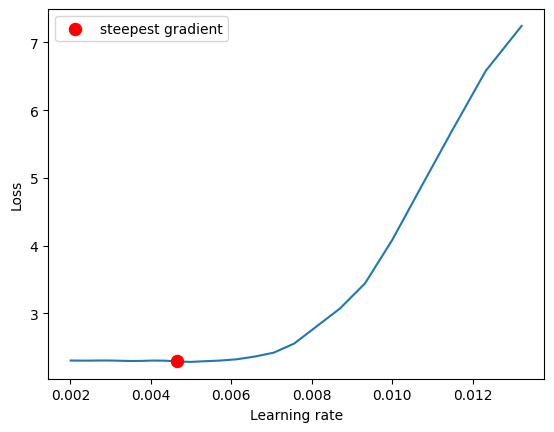

(<AxesSubplot: xlabel='Learning rate', ylabel='Loss'>, 0.004641588833612778)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer_ocp = optim.SGD(model_copy.parameters(), lr=0.001, momentum=0.9)
lr_finder = LRFinder(model_copy, optimizer_ocp, criterion, device=device)
lr_finder.range_test(cifar10_trainloader_ocp, val_loader=cifar10_testloader_ocp, end_lr=1, num_iter=100, step_mode='exp')
lr_finder.plot(log_lr=False)

In [19]:
lr_finder.reset()

In [ ]:
device

In [ ]:
#lr_finder.plot()

In [13]:
min_loss = min(lr_finder.history['loss'])
lr_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR: ", lr_rate)

Max LR:  0.03593813663804627


In [ ]:
#lr late is the max LR from lr_finder

In [ ]:
#ocp_lr = 0.206 #steepest gradient

In [21]:
cifar10_trainloader, cifar10_testloader = get_augmented_cifar10_dataset("/home/raghuc/work/data/", train_tfms=assn8_train_transforms, test_tfms=assn8_test_transforms, batch_sz=512)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
optimizer = torch.optim.SGD(custom_resnet.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr_rate, steps_per_epoch=len(cifar10_trainloader), epochs=24, pct_start=0.2, div_factor=10, three_phase=False, final_div_factor=50,anneal_strategy='linear')

In [23]:
EPOCHS = 24

train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(custom_resnet, device, cifar10_trainloader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    test(custom_resnet, device, cifar10_testloader, test_losses, test_acc)

EPOCH: 0


Loss=1.8182588815689087 Batch_id=97 Accuracy=26.68: 100%|███████████████████████████| 98/98 [00:16<00:00,  5.88it/s]



Test set: Average loss: 1.7740, Accuracy: 4090/10000 (40.90%)

EPOCH: 1


Loss=1.6115758419036865 Batch_id=97 Accuracy=40.51: 100%|███████████████████████████| 98/98 [00:16<00:00,  5.86it/s]



Test set: Average loss: 1.5210, Accuracy: 4950/10000 (49.50%)

EPOCH: 2


Loss=1.399137020111084 Batch_id=97 Accuracy=46.55: 100%|████████████████████████████| 98/98 [00:16<00:00,  5.83it/s]



Test set: Average loss: 1.2735, Accuracy: 5465/10000 (54.65%)

EPOCH: 3


Loss=1.4789669513702393 Batch_id=97 Accuracy=50.64: 100%|███████████████████████████| 98/98 [00:16<00:00,  5.81it/s]



Test set: Average loss: 1.2150, Accuracy: 5734/10000 (57.34%)

EPOCH: 4


Loss=1.1961450576782227 Batch_id=97 Accuracy=54.17: 100%|███████████████████████████| 98/98 [00:16<00:00,  5.79it/s]



Test set: Average loss: 0.9929, Accuracy: 6540/10000 (65.40%)

EPOCH: 5


Loss=1.1587388515472412 Batch_id=97 Accuracy=56.90: 100%|███████████████████████████| 98/98 [00:16<00:00,  5.79it/s]



Test set: Average loss: 0.8998, Accuracy: 6809/10000 (68.09%)

EPOCH: 6


Loss=1.0813579559326172 Batch_id=97 Accuracy=59.36: 100%|███████████████████████████| 98/98 [00:16<00:00,  5.79it/s]



Test set: Average loss: 0.8897, Accuracy: 6912/10000 (69.12%)

EPOCH: 7


Loss=1.1161937713623047 Batch_id=97 Accuracy=60.91: 100%|███████████████████████████| 98/98 [00:16<00:00,  5.77it/s]



Test set: Average loss: 0.7942, Accuracy: 7241/10000 (72.41%)

EPOCH: 8


Loss=0.8897978663444519 Batch_id=97 Accuracy=63.62: 100%|███████████████████████████| 98/98 [00:16<00:00,  5.77it/s]



Test set: Average loss: 0.8365, Accuracy: 7210/10000 (72.10%)

EPOCH: 9


Loss=0.9273066520690918 Batch_id=97 Accuracy=64.34: 100%|███████████████████████████| 98/98 [00:16<00:00,  5.77it/s]



Test set: Average loss: 0.7167, Accuracy: 7545/10000 (75.45%)

EPOCH: 10


Loss=0.9370352625846863 Batch_id=97 Accuracy=65.88: 100%|███████████████████████████| 98/98 [00:16<00:00,  5.78it/s]



Test set: Average loss: 0.7770, Accuracy: 7414/10000 (74.14%)

EPOCH: 11


Loss=0.9702231287956238 Batch_id=97 Accuracy=66.84: 100%|███████████████████████████| 98/98 [00:16<00:00,  5.77it/s]



Test set: Average loss: 0.7249, Accuracy: 7508/10000 (75.08%)

EPOCH: 12


Loss=0.8584591150283813 Batch_id=97 Accuracy=68.68: 100%|███████████████████████████| 98/98 [00:17<00:00,  5.74it/s]



Test set: Average loss: 0.6881, Accuracy: 7703/10000 (77.03%)

EPOCH: 13


Loss=0.95001220703125 Batch_id=97 Accuracy=68.96: 100%|█████████████████████████████| 98/98 [00:17<00:00,  5.75it/s]



Test set: Average loss: 0.6680, Accuracy: 7838/10000 (78.38%)

EPOCH: 14


Loss=0.8458928465843201 Batch_id=97 Accuracy=69.44: 100%|███████████████████████████| 98/98 [00:17<00:00,  5.75it/s]



Test set: Average loss: 0.6103, Accuracy: 7933/10000 (79.33%)

EPOCH: 15


Loss=0.8848398327827454 Batch_id=97 Accuracy=69.82: 100%|███████████████████████████| 98/98 [00:17<00:00,  5.74it/s]



Test set: Average loss: 0.8234, Accuracy: 7427/10000 (74.27%)

EPOCH: 16


Loss=0.7775189280509949 Batch_id=97 Accuracy=70.11: 100%|███████████████████████████| 98/98 [00:17<00:00,  5.74it/s]



Test set: Average loss: 0.5972, Accuracy: 8015/10000 (80.15%)

EPOCH: 17


Loss=0.7557829022407532 Batch_id=97 Accuracy=71.59: 100%|███████████████████████████| 98/98 [00:17<00:00,  5.72it/s]



Test set: Average loss: 0.5596, Accuracy: 8109/10000 (81.09%)

EPOCH: 18


Loss=0.8046663403511047 Batch_id=97 Accuracy=72.78: 100%|███████████████████████████| 98/98 [00:17<00:00,  5.72it/s]



Test set: Average loss: 0.5909, Accuracy: 8051/10000 (80.51%)

EPOCH: 19


Loss=0.9019840955734253 Batch_id=97 Accuracy=73.26: 100%|███████████████████████████| 98/98 [00:17<00:00,  5.75it/s]



Test set: Average loss: 0.6019, Accuracy: 8019/10000 (80.19%)

EPOCH: 20


Loss=0.7698097229003906 Batch_id=97 Accuracy=73.68: 100%|███████████████████████████| 98/98 [00:17<00:00,  5.74it/s]



Test set: Average loss: 0.5891, Accuracy: 8075/10000 (80.75%)

EPOCH: 21


Loss=0.7700914740562439 Batch_id=97 Accuracy=74.55: 100%|███████████████████████████| 98/98 [00:17<00:00,  5.74it/s]



Test set: Average loss: 0.5903, Accuracy: 8070/10000 (80.70%)

EPOCH: 22


Loss=0.6642088890075684 Batch_id=97 Accuracy=74.90: 100%|███████████████████████████| 98/98 [00:17<00:00,  5.76it/s]



Test set: Average loss: 0.5450, Accuracy: 8207/10000 (82.07%)

EPOCH: 23


Loss=0.6757044196128845 Batch_id=97 Accuracy=75.46: 100%|███████████████████████████| 98/98 [00:17<00:00,  5.75it/s]



Test set: Average loss: 0.5468, Accuracy: 8210/10000 (82.10%)

